In [97]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import experimentos_sa
import experimentos

import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import json
importlib.reload(experimentos_sa)

<module 'experimentos_sa' from 'c:\\dev\\BH\\planejamento-florestal\\T2-BH\\T2\\experimentos_sa.py'>

# Carregamento

In [98]:
def numpy_to_python(obj):
    '''Converte np.int e np.float para int e float dos dados do dicionário'''
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    
def python_to_numpy(dicionario):
    '''Converte int e float para np.int e np.float dos dados do dicionário'''
    for chave, subdict in dicionario.items():
        for subchave, valor in subdict.items():
            if isinstance(valor, int):
                subdict[subchave] = np.int64(valor)
            elif isinstance(valor, float):
                subdict[subchave] = np.float64(valor)
                
    dicionario = {np.int64(key): valor for key, valor in dicionario.items()}
    return dicionario

In [99]:
# Carrega os experimentos do SA
num_calculos_obj = [5000, 10000, 25000, 50000]

caminho_v1 = 'bkp_resultados_sa/sa_v1_experimentos.json'
with open(caminho_v1, 'r', encoding='utf-8') as arquivo:
    v1 = python_to_numpy(json.load(arquivo))
    v1_resultados = experimentos_sa.experimento(v1, num_calculos_obj)
    v1_resultados.calcula_estatisticas()
    
caminho_v2 = 'bkp_resultados_sa/sa_v2_experimentos.json'
with open(caminho_v2, 'r', encoding='utf-8') as arquivo:
    v2 = python_to_numpy(json.load(arquivo))
    v2_resultados = experimentos_sa.experimento(v2, num_calculos_obj)
    v2_resultados.calcula_estatisticas()

# Resultados Simulated Annealing

## Comparações numéricas das vizinhanças e métodos com valor de referência

Valor de referência: R$ 32.170.883

$$Eficiência = \frac{VPL_{Médio}}{VPL_{Referência}}$$

In [100]:
def dicionarios_para_dataframe(dicionarios, nomes):
    dados = []
    indices = []
    for nome, dicionario in zip(nomes, dicionarios):
        for num_calculos, metodos in dicionario.items():
            for metodo, valores in metodos.items():
                indices.append((nome, metodo, num_calculos))
                dados.append([valores["media"], valores["maximo"], valores["minimo"]])
    # Criar o DataFrame com índice no formato de tuplas
    df = pd.DataFrame(dados, 
                      index=pd.MultiIndex.from_tuples(indices, names=["Vn", "Metodo", "NumCalculos"]),
                      columns=["Media", "Maximo", "Minimo"])
    
    # Calcular a eficiência (Média / 32170883)
    df["Eficiência"] = df["Media"] / 32170883
    
    # Definir a exibição de números para evitar notação científica
    pd.set_option('display.float_format', '{:,.3f}'.format)
    
    return df


# Criar o DataFrame
dfs = [v1_resultados.estatisticas, v2_resultados.estatisticas]
nomes = ["Aleatória", "Localizada", "Sistemática"]
df = dicionarios_para_dataframe(dfs, nomes)

# Exibir o DataFrame
df = df[df.index.get_level_values('Metodo') != 'mm']
df
df.groupby(["Vn", "NumCalculos"]).mean().sort_values(by=["Eficiência"], ascending=False)

,,Media,Maximo,Minimo,Eficiência
Vn,NumCalculos,,,,
Aleatória,50000,"30,811,727.267","30,939,849.000","30,536,352.000",0.958
Localizada,50000,"30,797,092.867","30,912,976.000","30,680,261.000",0.957
Aleatória,25000,"30,623,788.533","30,903,224.000","30,448,667.000",0.952
Localizada,25000,"30,544,168.533","30,762,503.000","30,314,710.000",0.949
Aleatória,10000,"30,226,367.133","30,439,430.000","30,066,828.000",0.940
Localizada,10000,"30,203,581.400","30,479,174.000","30,014,130.000",0.939
Aleatória,5000,"30,049,511.467","30,325,327.000","29,755,073.000",0.934
Localizada,5000,"30,016,152.000","30,182,183.000","29,898,104.000",0.933


## Comparação do VPL médio das diferentes vizinhanças

In [101]:
# Pega melhor método de cada experimento

v1_sa_media = []
for chave, subdict in v1_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'pm':
            v1_sa_media.append(valor.get('media'))
            
v2_sa_media = []
for chave, subdict in v2_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'pm':
            v2_sa_media.append(valor.get('media'))
            

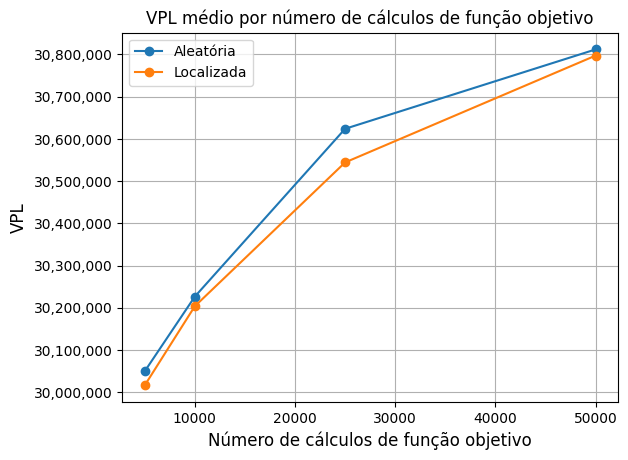

In [102]:
plt.plot(v1_resultados.num_calculos_obj, 
         v1_sa_media, 
         label='Aleatória', 
         marker='o')
plt.plot(v2_resultados.num_calculos_obj, 
         v2_sa_media, 
         label='Localizada', 
         marker='o')

plt.title('VPL médio por número de cálculos de função objetivo')
plt.xlabel('Número de cálculos de função objetivo', fontsize=12)
plt.ylabel('VPL', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.ticklabel_format(style='plain', axis='x') 
plt.legend()
plt.grid()
plt.show()

## Comparação entre meta-heurísticas

In [103]:
# Carrega os experimentos do SA
num_calculos_obj = [5000, 10000, 25000, 50000]

caminho_v1_bl = '../Busca_local/bkp_resultados_bl/v1_experimentos.json'
with open(caminho_v1_bl, 'r', encoding='utf-8') as arquivo:
    v1_bl = python_to_numpy(json.load(arquivo))
    v1_bl_resultados = experimentos.experimento(v1_bl, num_calculos_obj)
    v1_bl_resultados.calcula_estatisticas()
    
caminho_v2_bl = '../Busca_local/bkp_resultados_bl/v2_experimentos.json'
with open(caminho_v2_bl, 'r', encoding='utf-8') as arquivo:
    v2_bl = python_to_numpy(json.load(arquivo))
    v2_bl_resultados = experimentos.experimento(v2_bl, num_calculos_obj)
    v2_bl_resultados.calcula_estatisticas()
    
caminho_v3_bl = '../Busca_local/bkp_resultados_bl/v3_experimentos.json'
with open(caminho_v3_bl, 'r', encoding='utf-8') as arquivo:
    v3_bl = python_to_numpy(json.load(arquivo))
    v3_bl_resultados = experimentos.experimento(v3_bl, num_calculos_obj)
    v3_bl_resultados.calcula_estatisticas()

In [104]:
# Pega melhor método de cada experimento

v1_mm_media = []
for chave, subdict in v1_bl_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'mm':
            v1_mm_media.append(valor.get('media'))
            
v2_mm_media = []
for chave, subdict in v2_bl_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'mm':
            v2_mm_media.append(valor.get('media'))
            
v3_pm_media = []
for chave, subdict in v3_bl_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'pm':
            v3_pm_media.append(valor.get('media'))

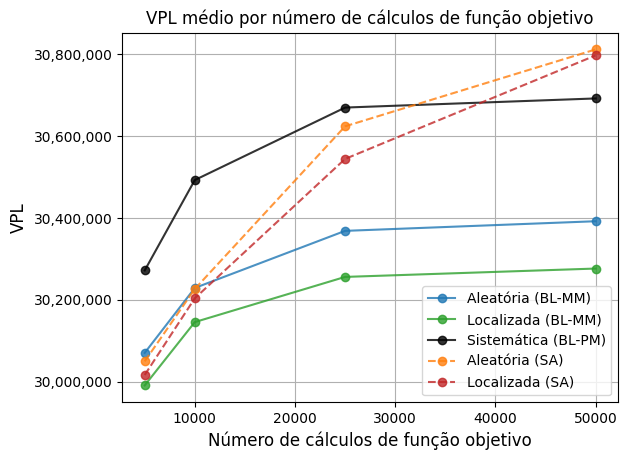

In [105]:
import matplotlib.ticker as ticker

plt.plot(v1_bl_resultados.num_calculos_obj, 
         v1_mm_media, 
         label='Aleatória (BL-MM)', 
         color='#1f77b4', 
         marker='o', alpha=.8)
plt.plot(v2_bl_resultados.num_calculos_obj, 
         v2_mm_media, 
         label='Localizada (BL-MM)', 
         color='#2ca02c', 
         marker='o', alpha=.8)
plt.plot(v3_bl_resultados.num_calculos_obj, 
         v3_pm_media, 
         label='Sistemática (BL-PM)', 
        color='#000000', 
         marker='o', alpha=.8)
plt.plot(v1_resultados.num_calculos_obj, 
         v1_sa_media, 
         label='Aleatória (SA)', 
         color='#ff7f0e', 
         marker='o',
         linestyle='--', alpha=.8)
plt.plot(v2_resultados.num_calculos_obj, 
         v2_sa_media, 
         label='Localizada (SA)', 
         color='#c12728', 
         marker='o',
         linestyle='--', alpha=.8)

plt.title('VPL médio por número de cálculos de função objetivo')
plt.xlabel('Número de cálculos de função objetivo', fontsize=12)
plt.ylabel('VPL', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.ticklabel_format(style='plain', axis='x') 
plt.legend()
plt.grid()
plt.show()
